In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

Converting all the date values to datetime objects

Also create a new feature called 'advance_searched' which is the difference between the check in time and the date of the search to quantify how far in advance the user is looking to book.

In [ ]:
contacts = pd.read_csv('/work/contacts.tsv', sep='\t')
searches = pd.read_csv('/work/searches.tsv', sep='\t')
searches['ds'] = pd.to_datetime(searches['ds'])
searches['ds_checkin'] = pd.to_datetime(searches['ds_checkin'])
searches['ds_checkout'] = pd.to_datetime(searches['ds_checkout'])
searches['advance_searched'] = (searches['ds_checkin'] - searches['ds'].dt.normalize()).dt.days

contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_length'] = (contacts['ds_checkout'] - contacts['ds_checkin']).dt.days

Merge the searches and contacts df on id_user=id_guest, ds_checkin, and ds_checkout. This is to match up contacts that actually occurred with their corresponding searches. 

In [ ]:
merged_data = contacts.merge(searches, right_on=['id_user', 'ds_checkin', 'ds_checkout'], left_on=['id_guest', 'ds_checkin', 'ds_checkout'], how='left')

In [ ]:
len(merged_data)

13764

In [ ]:
merged_data['booked'] = merged_data['ts_booking_at'].notnull()

features = ['ds', 'ds_checkin', 'ds_checkout', 'n_searches', 'n_nights', 'n_guests_min', 'n_guests_max', 'origin_country', 'filter_price_min', 'filter_price_max', 'advance_searched', 'booked']
merged_data = merged_data[features]

merged_data

,ds,ds_checkin,ds_checkout,n_searches,n_nights,n_guests_min,n_guests_max,origin_country,filter_price_min,filter_price_max,advance_searched,booked
0,2014-10-04,2014-10-13,2014-10-15,6,2.0,2,2,CA,0.0,1.300000e+02,9.0,True
1,2014-10-14,2014-11-27,2014-11-30,13,3.0,1,1,DK,0.0,3.360000e+02,44.0,True
2,2014-10-09,2014-10-17,2014-10-19,21,2.0,2,2,CY,0.0,1.258000e+03,8.0,False
3,2014-10-10,2014-10-17,2014-10-19,44,2.0,2,2,CY,0.0,2.140000e+02,7.0,False
4,2014-10-09,2014-10-17,2014-10-19,21,2.0,2,2,CY,0.0,1.258000e+03,8.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
13759,2014-10-06,2014-10-17,2014-10-20,21,3.0,2,2,IT,0.0,8.500000e+01,11.0,False
13760,2014-10-07,2014-10-17,2014-10-20,20,3.0,2,2,IT,0.0,8.500000e+01,10.0,False
13761,2014-10-12,2014-10-17,2014-10-20,13,3.0,1,2,IT,0.0,1.073742e+09,5.0,False
13762,2014-10-13,2014-10-17,2014-10-20,10,3.0,2,2,IT,0.0,1.050000e+02,4.0,False


In [ ]:
features = ['ds', 'n_nights', 'n_guests_max',  'advance_searched', 'booked']
final_data = merged_data[features]
final_data = final_data.dropna()
final_data

,ds,n_nights,n_guests_max,advance_searched,booked
0,2014-10-04,2.0,2,9.0,True
1,2014-10-14,3.0,1,44.0,True
2,2014-10-09,2.0,2,8.0,False
3,2014-10-10,2.0,2,7.0,False
4,2014-10-09,2.0,2,8.0,False
...,...,...,...,...,...
13759,2014-10-06,3.0,2,11.0,False
13760,2014-10-07,3.0,2,10.0,False
13761,2014-10-12,3.0,2,5.0,False
13762,2014-10-13,3.0,2,4.0,False


The predictors for this model will be n_nights, n_guests_max, and advance_searched and our response variable will be booked which is a binary feature, 0 when they did not get booked and 1 when they did get booked.

In [ ]:
predictors = ['n_nights', 'n_guests_max', 'advance_searched']
X = final_data[predictors]
y = final_data['booked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Below we weight the penalty of errors on the booked class higher since it is an under represented class. We could have also attempted undersampling the unbooked class, oversampling the booked class, or generating synthetic values of the booked class to bring more balance between the two classes.

In [ ]:
class_weight= {0:4, 1:9}
LRmodel = LogisticRegression(class_weight=class_weight)

LRmodel.fit(X_train, y_train)

LogisticRegression(class_weight={0: 4, 1: 9})

In [ ]:
y_pred = LRmodel.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.92      0.83      2052
        True       0.33      0.11      0.17       701

    accuracy                           0.72      2753
   macro avg       0.54      0.52      0.50      2753
weighted avg       0.64      0.72      0.66      2753

[[1893  159]
 [ 623   78]]


Our confusion matrix shows our model is terrible at accurately predicting when people will be booked based on the given predictors 

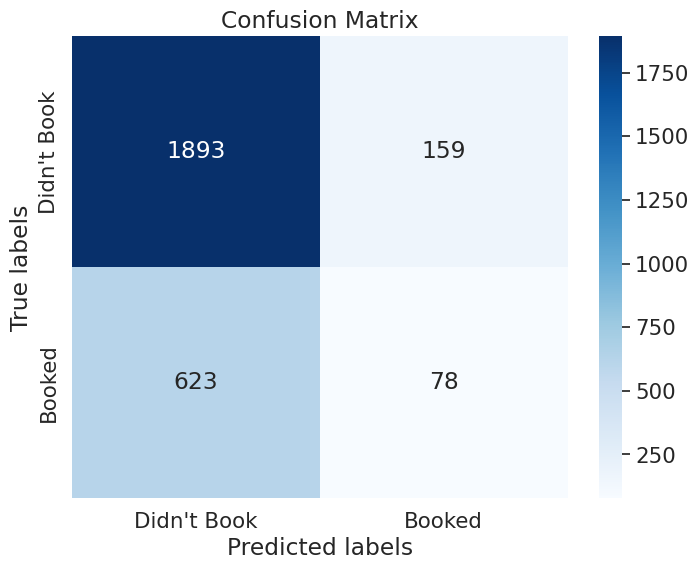

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size

class_names = ['Didn\'t Book', 'Booked']  # Class 0 = Didn't Book, Class 1 = Booked
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)  # 'fmt' is a string formatting code

# Adding labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Given more time, we could have explored more feature combinations as well as different classification models. The current state of this model is very poor and has a lot of room for improvement.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b437c3b3-3aa6-4b0e-b468-e8e7345d65e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>